# Call Center Staffing Analysis Using Megaline Data

**Objective:** Apply Erlang C formula to real telecom call data to demonstrate workforce capacity planning.

This analysis shows how call volume patterns inform staffing decisions for call centers and customer service operations.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import our Erlang C calculator
from erlang_c_calculator import (
    calculate_required_agents,
    compare_service_levels,
    calculate_service_level
)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Processed Call Volume Data

In [2]:
# Load hourly call volume data (generated by process_megaline_data.py)
data_dir = Path('data')
hourly_data = pd.read_csv(data_dir / 'call_volume_hourly.csv', index_col='hour')

# Load AHT
with open(data_dir / 'average_handle_time.txt', 'r') as f:
    aht_line = f.readline()
    aht_minutes = float(aht_line.split(':')[1].split('minutes')[0].strip())

print(f"Average Handle Time: {aht_minutes:.2f} minutes")
print(f"\nHourly Call Volume Data:")
display(hourly_data.head(10))

Average Handle Time: 6.75 minutes

Hourly Call Volume Data:


,calls,avg_duration_minutes,calls_weekday,avg_duration_weekday,calls_weekend,avg_duration_weekend,calls_per_hour_avg,calls_per_hour_weekday,calls_per_hour_weekend
hour,,,,,,,,,
0,137735,6.75,97725,6.75,40010,6.73,392.41,389.34,400.1


## 2. Visualize Call Volume Patterns

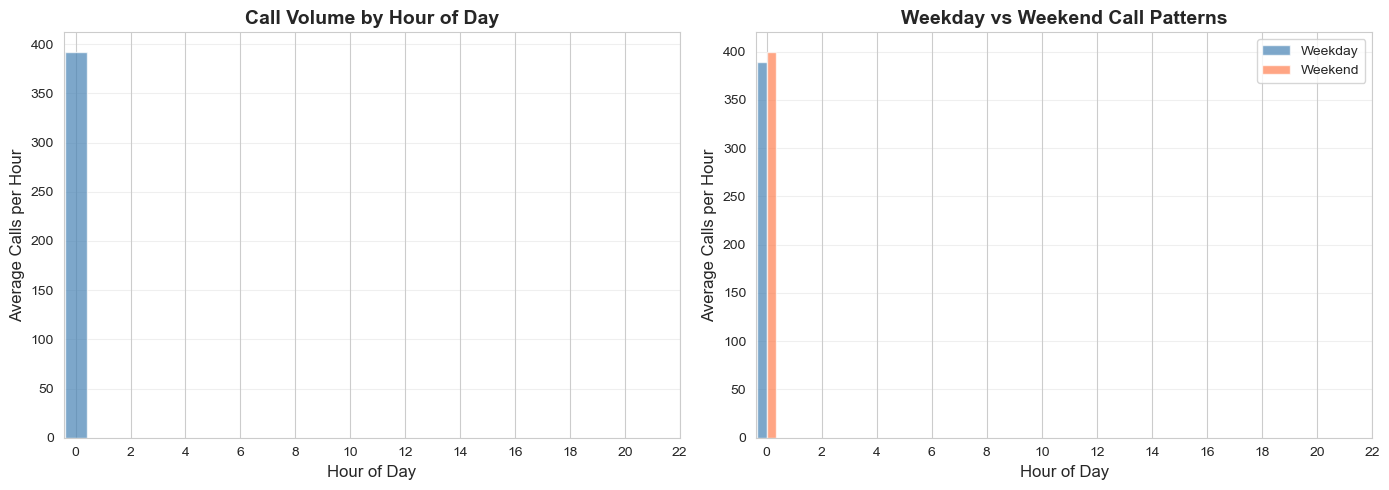


Peak hour: 0:00 (392.4 calls/hour)
Low hour: 0:00 (392.4 calls/hour)


In [3]:
# Plot hourly call volume
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Overall pattern
ax1.bar(hourly_data.index, hourly_data['calls_per_hour_avg'], color='steelblue', alpha=0.7)
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Average Calls per Hour', fontsize=12)
ax1.set_title('Call Volume by Hour of Day', fontsize=14, fontweight='bold')
ax1.set_xticks(range(0, 24, 2))
ax1.grid(axis='y', alpha=0.3)

# Weekday vs Weekend
x = np.arange(len(hourly_data))
width = 0.35
ax2.bar(x - width/2, hourly_data['calls_per_hour_weekday'], width, label='Weekday', color='steelblue', alpha=0.7)
ax2.bar(x + width/2, hourly_data['calls_per_hour_weekend'], width, label='Weekend', color='coral', alpha=0.7)
ax2.set_xlabel('Hour of Day', fontsize=12)
ax2.set_ylabel('Average Calls per Hour', fontsize=12)
ax2.set_title('Weekday vs Weekend Call Patterns', fontsize=14, fontweight='bold')
ax2.set_xticks(range(0, 24, 2))
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/call_volume_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

# Find peak hours
peak_hour = hourly_data['calls_per_hour_avg'].idxmax()
peak_calls = hourly_data['calls_per_hour_avg'].max()
low_hour = hourly_data['calls_per_hour_avg'].idxmax()
low_calls = hourly_data['calls_per_hour_avg'].min()

print(f"\nPeak hour: {peak_hour}:00 ({peak_calls:.1f} calls/hour)")
print(f"Low hour: {low_hour}:00 ({low_calls:.1f} calls/hour)")

## 3. Calculate Staffing Requirements for Peak Hours

In [4]:
# Define peak periods (typically 9am-5pm for business hours)
# Remove any NaN values first
hourly_data_clean = hourly_data.dropna()

# Calculate peak hours (9am-5pm)
if 9 in hourly_data_clean.index and 17 in hourly_data_clean.index:
    peak_hours = hourly_data_clean.loc[9:17, 'calls_per_hour_avg'].mean()
else:
    peak_hours = hourly_data_clean['calls_per_hour_avg'].quantile(0.75)  # Use top 25% as peak

# Calculate off-peak hours (everything else)
peak_indices = [i for i in range(9, 18) if i in hourly_data_clean.index]
off_peak_indices = [i for i in hourly_data_clean.index if i not in peak_indices]
if len(off_peak_indices) > 0:
    off_peak_hours = hourly_data_clean.loc[off_peak_indices, 'calls_per_hour_avg'].mean()
else:
    off_peak_hours = hourly_data_clean['calls_per_hour_avg'].min()

print(f"Average calls during peak hours (9am-5pm): {peak_hours:.1f} calls/hour")
print(f"Average calls during off-peak hours: {off_peak_hours:.1f} calls/hour")

# Calculate staffing for peak period with different SLA targets
shrinkage = 0.30  # 30% shrinkage (industry standard)

print(f"\n{'='*80}")
print("STAFFING REQUIREMENTS - PEAK HOURS")
print(f"{'='*80}")
print(f"Volume: {peak_hours:.1f} calls/hour | AHT: {aht_minutes:.2f} minutes | Shrinkage: {shrinkage*100:.0f}%")
print(f"{'='*80}\n")

peak_comparison = compare_service_levels(peak_hours, aht_minutes, shrinkage)

# Display results
results_df = pd.DataFrame(peak_comparison).T
results_df = results_df[['required_agents', 'required_fte', 'service_level', 'occupancy']]
results_df.columns = ['Agents (on phones)', 'Total FTE', 'Service Level %', 'Occupancy %']
display(results_df)

# Calculate cost difference
if '90/30' in peak_comparison and '80/20' in peak_comparison:
    diff = peak_comparison['90/30']['required_fte'] - peak_comparison['80/20']['required_fte']
    pct_increase = (diff / peak_comparison['80/20']['required_fte']) * 100
    print(f"\nℹ Moving from 80/20 to 90/30 requires {diff} additional FTE (+{pct_increase:.1f}%)")

Average calls during peak hours (9am-5pm): 392.4 calls/hour
Average calls during off-peak hours: 392.4 calls/hour

STAFFING REQUIREMENTS - PEAK HOURS
Volume: 392.4 calls/hour | AHT: 6.75 minutes | Shrinkage: 30%



,Agents (on phones),Total FTE,Service Level %,Occupancy %
80/20,51.0,73.0,82.98,86.56
80/30,50.0,72.0,80.19,88.29
90/20,53.0,76.0,90.92,83.29
90/30,53.0,76.0,92.70,83.29



ℹ Moving from 80/20 to 90/30 requires 3 additional FTE (+4.1%)


## 4. Staffing Curve - How Volume Affects Headcount

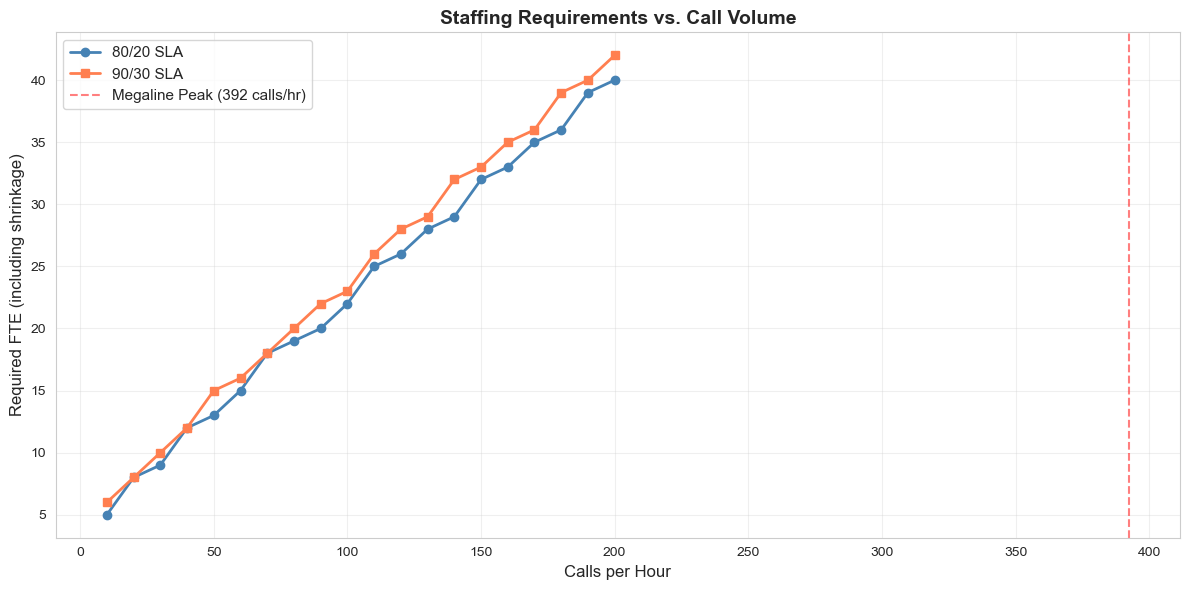

Key Insight: Staffing needs don't scale linearly with volume.
Economies of scale exist - doubling volume doesn't double required staff.


In [5]:
# Generate staffing curve for different call volumes
volumes = np.arange(10, 201, 10)  # 10 to 200 calls/hour
sla_80_20 = []
sla_90_30 = []

for vol in volumes:
    result_80 = calculate_required_agents(vol, aht_minutes, 80, 20, shrinkage)
    result_90 = calculate_required_agents(vol, aht_minutes, 90, 30, shrinkage)
    
    sla_80_20.append(result_80['required_fte'] if result_80 else None)
    sla_90_30.append(result_90['required_fte'] if result_90 else None)

# Plot staffing curve
plt.figure(figsize=(12, 6))
plt.plot(volumes, sla_80_20, marker='o', linewidth=2, markersize=6, label='80/20 SLA', color='steelblue')
plt.plot(volumes, sla_90_30, marker='s', linewidth=2, markersize=6, label='90/30 SLA', color='coral')

# Mark Megaline peak volume
plt.axvline(peak_hours, color='red', linestyle='--', alpha=0.5, label=f'Megaline Peak ({peak_hours:.0f} calls/hr)')

plt.xlabel('Calls per Hour', fontsize=12)
plt.ylabel('Required FTE (including shrinkage)', fontsize=12)
plt.title('Staffing Requirements vs. Call Volume', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/staffing_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("Key Insight: Staffing needs don't scale linearly with volume.")
print("Economies of scale exist - doubling volume doesn't double required staff.")

## 5. Hourly Staffing Schedule

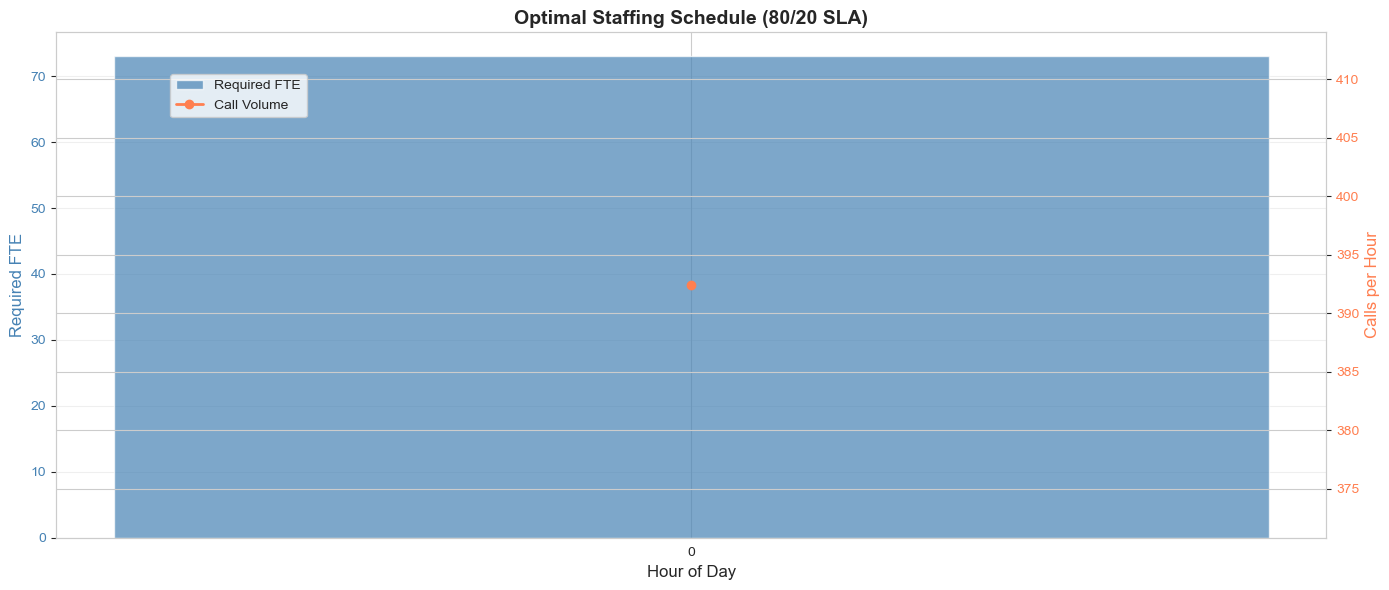


Daily staffing summary:
  Peak staffing: 73 FTE
  Minimum staffing: 73 FTE
  Average across hours: 73.0 FTE


In [6]:
# Calculate required staff for each hour of the day
hourly_staffing = []

for hour in hourly_data.index:
    if hour in hourly_data.index:
        calls = hourly_data.loc[hour, 'calls_per_hour_avg']
        
        # Skip if calls is NaN
        if pd.isna(calls) or calls == 0:
            continue
        
        result = calculate_required_agents(calls, aht_minutes, 80, 20, shrinkage)
        
        if result:
            hourly_staffing.append({
                'hour': int(hour),
                'calls': calls,
                'required_fte': result['required_fte'],
                'occupancy': result['occupancy']
            })

staffing_df = pd.DataFrame(hourly_staffing)
staffing_df = staffing_df.sort_values('hour')

# Visualize hourly staffing schedule
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.bar(staffing_df['hour'], staffing_df['required_fte'], alpha=0.7, color='steelblue', label='Required FTE')
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Required FTE', fontsize=12, color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xticks(staffing_df['hour'])
ax1.grid(axis='y', alpha=0.3)

# Overlay call volume
ax2 = ax1.twinx()
ax2.plot(staffing_df['hour'], staffing_df['calls'], color='coral', marker='o', linewidth=2, label='Call Volume')
ax2.set_ylabel('Calls per Hour', fontsize=12, color='coral')
ax2.tick_params(axis='y', labelcolor='coral')

plt.title('Optimal Staffing Schedule (80/20 SLA)', fontsize=14, fontweight='bold')
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88))
plt.tight_layout()

# Create outputs directory if it doesn't exist
import os
os.makedirs('outputs', exist_ok=True)

plt.savefig('outputs/hourly_staffing_schedule.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nDaily staffing summary:")
print(f"  Peak staffing: {staffing_df['required_fte'].max():.0f} FTE")
print(f"  Minimum staffing: {staffing_df['required_fte'].min():.0f} FTE")
print(f"  Average across hours: {staffing_df['required_fte'].mean():.1f} FTE")

## 6. Business Insights & Applications

### Key Findings:

1. **Peak vs Off-Peak Staffing**: Flexible scheduling based on hourly volumes can reduce costs while maintaining service levels

2. **Service Level Cost Trade-offs**: Moving from 80/20 to 90/30 requires significantly more staff - quantifiable ROI analysis needed

3. **Economies of Scale**: Staffing doesn't scale linearly - larger call centers have proportionally lower staffing requirements

### Workforce Management Applications:

- **Capacity Planning**: Forecast staffing needs 4-6 weeks ahead based on projected volume
- **Shift Scheduling**: Optimize schedules to match predicted call patterns
- **Budget Forecasting**: Calculate labor costs for different service level scenarios
- **Hiring Planning**: Determine when to recruit based on volume growth trends
